# Demo Monte Carlo Halo Population

This notebook demonstrates how to use DiffprofPop to generate a Monte Carlo realization of the halo population. 

The way this calculation is intended to work is that first we calculate $\langle\log_{10}c(t)\vert M_0,p_{50\%}\rangle$ using differentiable methods, then we calculate a Monte Carlo realization of the halo population and calculate this average manually, and they should agree. However, in the current code they do not. I am not sure whether the bug is in the Diffprof library, or if I am simply incorrectly calling our functions. Either way, this is a bug we need to resolve before publishing.

I have written a unit test in the `test_mc_diffprofpop.py` module that fails due to this issue. So either that unit test is incorrectly written, or the source code needs to be modified. That unit test is based directly on this notebook.

In [1]:
from jax import random as jran
ran_key = jran.PRNGKey(0)

In [2]:
tarr = np.linspace(1, 13.8, 30)
lgtarr = np.log10(tarr)
n_p = 100
p50_arr = np.linspace(0.1, 0.9, n_p)
lgm0 = 12
zz = np.zeros_like(tarr)

In [3]:
from diffprof.diffprofpop import get_singlemass_params_p50
from diffprof.dpp_predictions import get_predictions_from_singlemass_params_p50
from diffprof.dpp_opt import get_u_param_grids

ran_key, dpp_preds_key = jran.split(ran_key, 2)

singlemass_dpp_params = get_singlemass_params_p50(lgm0)
u_param_grids = get_u_param_grids(ran_key, 30_000)

u_be_grid, u_lgtc_bl_grid = u_param_grids
args = (singlemass_dpp_params, tarr, p50_arr, u_be_grid, u_lgtc_bl_grid)
dpp_preds = get_predictions_from_singlemass_params_p50(*args)
avg_log_conc_p50_dpp, avg_log_conc_lgm0_dpp = dpp_preds[:2]
std_log_conc_lgm0_dpp, std_log_conc_p50_dpp = dpp_preds[2:]

In [4]:
avg_log_conc_p50_dpp.shape

(100, 30)

In [5]:
from diffprof.mc_diffprofpop import mc_halo_population_singlemass

ran_key, mc_dpp_key = jran.split(ran_key, 2)

n_sample_per_p = 500
zz = np.zeros(n_sample_per_p)
p50_early = p50_arr[0]+zz
p50_late = p50_arr[-1]+zz

lgc_sample_early = mc_halo_population_singlemass(ran_key, tarr, p50_arr[0]+zz, singlemass_dpp_params)
lgc_sample_late = mc_halo_population_singlemass(ran_key, tarr, p50_arr[-1]+zz, singlemass_dpp_params)

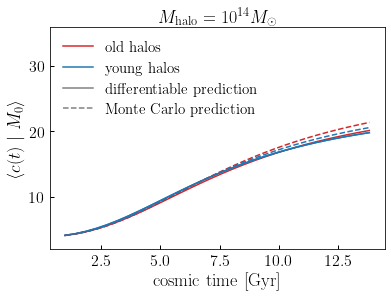

In [8]:
fig, ax = plt.subplots(1, 1)
ylim = ax.set_ylim(2, 36)

__=ax.plot(tarr, 10**avg_log_conc_p50_dpp[0, :], color=mred, label=r'${\rm old\ halos}$')
__=ax.plot(tarr, 10**avg_log_conc_p50_dpp[-1, :], color=mblue, label=r'${\rm young\ halos}$')
__=ax.plot(tarr, 10**avg_log_conc_p50_dpp[-1, :], color=mblue, label=r'${\rm differentiable\ prediction}$')

avg_lgc_sample_early = np.mean(lgc_sample_early, axis=0)
avg_lgc_sample_late = np.mean(lgc_sample_late, axis=0)
__=ax.plot(tarr, 10**avg_lgc_sample_early, '--', color=mred)
__=ax.plot(tarr, 10**avg_lgc_sample_late, '--', color=mblue, label=r'${\rm Monte\ Carlo\ prediction}$')

leg = ax.legend()
leg.legendHandles[2].set_color('gray')
leg.legendHandles[3].set_color('gray')
xlabel = ax.set_xlabel(r'${\rm cosmic\ time\ [Gyr]}$')
ylabel = ax.set_ylabel(r'$\langle c(t)\ \vert\ M_0\rangle$')
title = ax.set_title(r'$M_{\rm halo}=10^{14}M_{\odot}$')

In [7]:
lgc_sample_early.shape

(500, 30)